In [ ]:
#default_exp data

In [ ]:
#export
from timeseries_fastai.imports import *
from timeseries_fastai.core import *
from fastai.basics import *
from fastai.torch_core import *
from fastai.vision.data import get_grid

# Data
> DataBlock API to construct the DataLoaders

In [ ]:
#hide
from nbdev.showdoc import show_doc

We will create a DataBlock to process our UCR datasets

In [ ]:
ucr_path = untar_data(URLs.UCR)

In [ ]:
df_train, df_test = load_df_ucr(ucr_path, 'StarLightCurves')

Loading files from: /home/tcapelle/.fastai/data/Univariate2018_arff/StarLightCurves


In [ ]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att1016,att1017,att1018,att1019,att1020,att1021,att1022,att1023,att1024,target
0,0.537303,0.531103,0.528503,0.529403,0.533603,0.540903,0.551103,0.564003,0.579603,0.597603,...,0.546903,0.545903,0.543903,0.541003,0.537203,0.532303,0.526403,0.519503,0.511403,b'3'
1,0.588398,0.593898,0.599098,0.604098,0.608798,0.613397,0.617797,0.622097,0.626097,0.630097,...,0.237399,0.246499,0.256199,0.266499,0.277399,0.288799,0.300899,0.313599,0.326899,b'3'
2,-0.049900,-0.041500,-0.033400,-0.025600,-0.018100,-0.010800,-0.003800,0.003000,0.009600,0.015900,...,-0.173801,-0.161601,-0.149201,-0.136401,-0.123201,-0.109701,-0.095901,-0.081701,-0.067100,b'1'
3,1.337005,1.319805,1.302905,1.286305,1.270005,1.254005,1.238304,1.223005,1.208104,1.193504,...,1.288905,1.298505,1.307705,1.316505,1.324905,1.332805,1.340205,1.347005,1.353205,b'3'
4,0.769801,0.775301,0.780401,0.785101,0.789401,0.793301,0.796801,0.799901,0.802601,0.805101,...,0.742401,0.744501,0.747301,0.750701,0.754801,0.759501,0.765001,0.771301,0.778401,b'3'


In [ ]:
x_cols = df_train.columns[slice(0,-1)].to_list()
x_cols[0:5], x_cols[-1]

(['att1', 'att2', 'att3', 'att4', 'att5'], 'att1024')

In [ ]:
#export
def TSBlock(cls=TSeries): 
    "A TimeSeries Block to process one timeseries"
    return TransformBlock(type_tfms=cls.create)

In [ ]:
dblock = DataBlock(blocks=(TSBlock, CategoryBlock),
                           get_x=lambda o: o[x_cols].values.astype(np.float32),
                           get_y=ColReader('target'),
                           splitter=RandomSplitter(0.2))

A good way to debug the Block is using summary:

In [ ]:
dblock.summary(df_train)

Setting-up type transforms pipelines
0    0.537303  0.531103  0.528503  0.529403  0.533603  0.540903  0.551103   
1    0.588398  0.593898  0.599098  0.604098  0.608798  0.613397  0.617797   
2   -0.049900 -0.041500 -0.033400 -0.025600 -0.018100 -0.010800 -0.003800   
3    1.337005  1.319805  1.302905  1.286305  1.270005  1.254005  1.238304   
4    0.769801  0.775301  0.780401  0.785101  0.789401  0.793301  0.796801   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.751000 -0.749100 -0.747100 -0.745200 -0.743300 -0.741500 -0.739600   
996  0.867600  0.860300  0.853300  0.846500  0.840100  0.834000  0.828100   
997  0.087398  0.097398  0.107698  0.118298  0.129298  0.140398  0.151898   
998  0.664799  0.654799  0.646099  0.638599  0.632299  0.627199  0.623099   
999  0.563602  0.569502  0.574902  0.579702  0.583902  0.587702  0.591002   

         att8      att9     att10  ...   att1016   att1017   att1018  \
0    0.564003  0.579603  0.597603  ...  0.5

In [ ]:
dls = dblock.dataloaders(df_train, bs=4)

The `show_batch` method is not very practical, let's redefine it on the `DataLoader` class

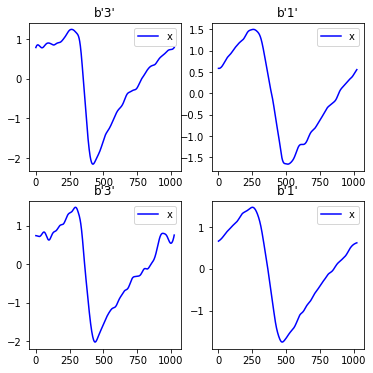

In [ ]:
dls.show_batch()

A handy function to stack `df_train` and `df_valid` together, adds column to know which is which.

In [ ]:
#export
def stack_train_valid(df_train, df_valid):
    "Stack df_train and df_valid, adds `valid_col`=True/False for df_valid/df_train"
    return pd.concat([df_train.assign(valid_col=False), df_valid.assign(valid_col=True)]).reset_index(drop=True)

## DataLoaders
> A custom TSeries DataLoaders class

In [ ]:
#export
class TSDataLoaders(DataLoaders):
    "A TimeSeries DataLoader"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, x_cols=None, label_col=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create a DataLoader from a pandas DataFrame"
        y_block = ifnone(y_block, CategoryBlock)
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(TSBlock, y_block),
                           get_x=lambda o: o[x_cols].values.astype(np.float32),
                           get_y=ColReader(label_col),
                           splitter=splitter,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_dfs(cls, df_train, df_valid, path='.', x_cols=None, label_col=None,
                y_block=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create a DataLoader from a df_train and df_valid"
        df = stack_train_valid(df_train, df_valid)
        return cls.from_df(df, path, x_cols=x_cols, valid_col='valid_col', label_col=label_col,
                y_block=y_block, item_tfms=item_tfms, batch_tfms=batch_tfms,**kwargs)

Overchaging `show_batch` function to add grid spacing.

In [ ]:
#export
@typedispatch
def show_batch(x: TSeries, y, samples, ctxs=None, max_n=10,rows=None, cols=None, figsize=None, **kwargs):
    "Show batch for TSeries objects"
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=rows, ncols=cols, add_vert=1, figsize=figsize)
    ctxs = show_batch[object](x, y, samples=samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

Let's test the DataLoader

In [ ]:
show_doc(TSDataLoaders.from_dfs)

<h4 id="TSDataLoaders.from_dfs" class="doc_header"><code>TSDataLoaders.from_dfs</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>TSDataLoaders.from_dfs</code>(**`df_train`**, **`df_valid`**, **`path`**=*`'.'`*, **`x_cols`**=*`None`*, **`label_col`**=*`None`*, **`y_block`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create a DataLoader from a df_train and df_valid

In [ ]:
dls = TSDataLoaders.from_dfs(df_train, df_test, x_cols=x_cols, label_col='target', bs=16, val_bs=64)

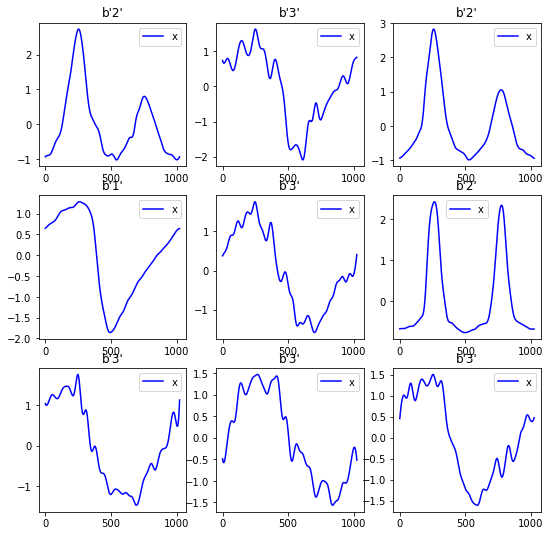

In [ ]:
dls.show_batch()

## Profiling the DataLoader

In [ ]:
len(dls.valid_ds)

8236

In [ ]:
def cycle_dl(dl):
    for x,y in iter(dl):
        pass

It is pretty slow

In [ ]:
%time cycle_dl(dls.valid)

CPU times: user 104 ms, sys: 389 ms, total: 493 ms
Wall time: 1.93 s


# Export -

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_models.ipynb.
Converted 03_tabular.ipynb.
Converted 04_testing.ipynb.
Converted 99_index.ipynb.
